# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

# Работа с таблицей и поиск аномалий

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

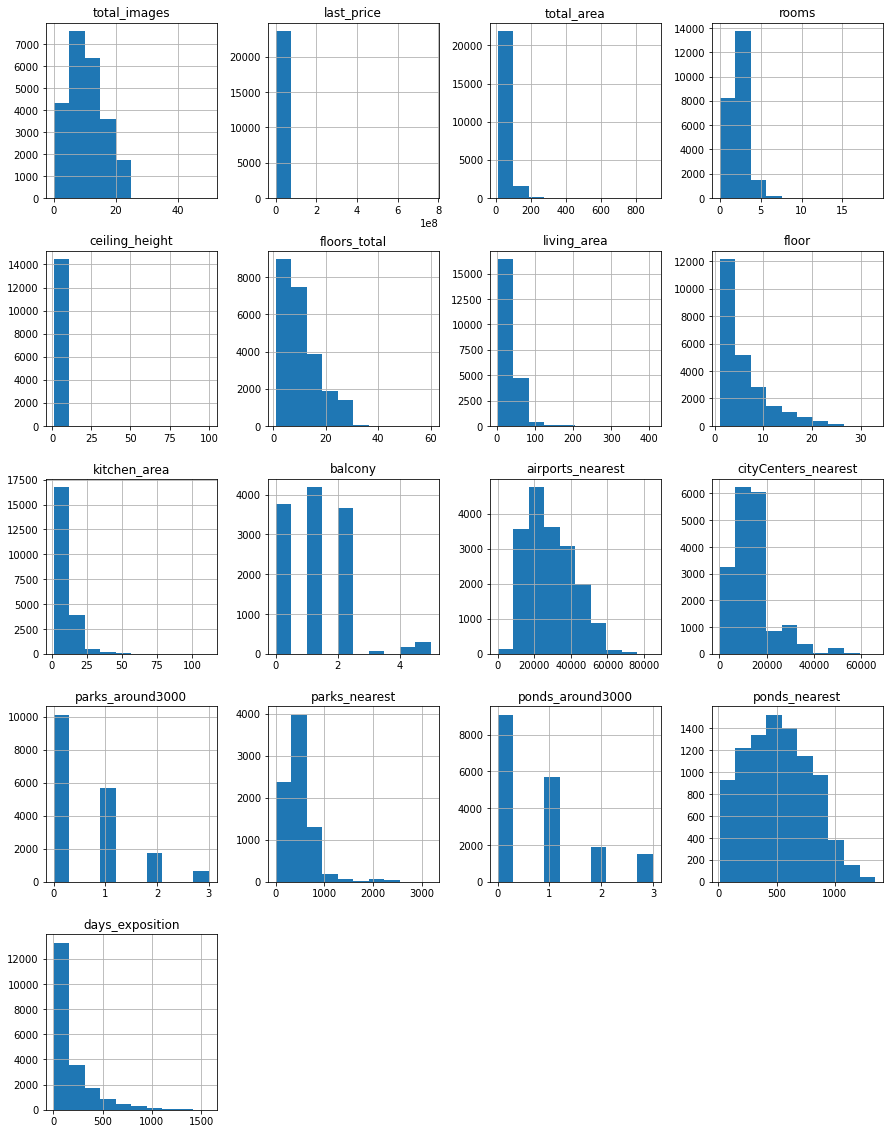

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep="\t")
data.info()


data.hist(figsize=(15, 20))
plt.show()

по первичному знакомству могу сказать что во многих данных есть выбросы, искажающие общее понимание графиков

# Предобработка данных

In [3]:
columns_fill_zero = ['parks_around3000', 'ponds_around3000', 'balcony']
for i in columns_fill_zero:
    data[i] = data[i].fillna(0)
    
data = data[data['floors_total']<=35]

data['is_apartment'] = data['is_apartment'].fillna(False)


In [4]:
for d in data['floor'].unique():
    data.loc[(data['floor'] == d) & (data['floors_total'].isna()), 'floors_total'] = \
    data.loc[(data['floor'] == d), 'floors_total'].median()

In [5]:
def categorize_area(area):
    try:
        if area <= 30:
            return 'small'
        elif area <= 50:
            return 'medium'
        elif area <= 70:
            return 'big'
        elif area <= 100:
            return 'very_big'
        elif area > 100:
            return 'lux'
    except:
        pass
    
data['total_area_category'] = data['total_area'].apply(categorize_area)

for d in data['total_area_category'].unique():
    data.loc[(data['total_area_category'] == d) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['total_area_category'] == d), 'kitchen_area'].median()
    
for d in data['total_area_category'].unique():
    data.loc[(data['total_area_category'] == d) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['total_area_category'] == d), 'living_area'].median()

In [6]:
# удалим возможные значения потолков ниже 2х метров
data = data[(data['ceiling_height'].isna()) | ((data['ceiling_height'] < 10) | (data['ceiling_height'] > 20))]
data = data[data.index != 22869]
# рассчитаем аномалии в высоте потолков
def solve_too_high_ceiling(ceiling):
    try:
        if ceiling > 10:
            return round(ceiling/10)
        
        else:
            return round(ceiling)
    except:
        pass
    
data['ceiling_height'] = data['ceiling_height'].apply(solve_too_high_ceiling).fillna(data['ceiling_height'].median())
data = data[data['ceiling_height'] != 1]

In [7]:
# преобразование из object в datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
# избавление от неявных дубликатов локаций и заполнение отсутствия
data['locality_name'] = (
    data['locality_name']
    .fillna('неизвестно')
    .str.lower()
    .str.replace('ё', 'е')
    .replace(['поселок', 'деревня','станции', 'городской', 'городского типа', 'село', 'садовое товарищество', 'коттеджный', 'при железнодорожной станции', ' '], '', regex=True)
)

пропуски могли появиться из-за ошибок тех, кто данные заполнял, предпочли скрыть изначальные данные при заполнении данных, ошибки программы

этажи я заполнял по медианным значениям тех этажей, где эти данные есть, так не получится случая, где квартира на 15 этаже в доме, где всего этажей 5, строки, где количество этажей было больше самой высокой башни в питере удалил, тк не знаю как их можно преобразовать

похожим образом хотел заполнить пропущенные значения площади жилой части и кухни, так как скорее всего чем больше квартира тем больше вероятность что площадь будет соотвествующая, но тк данные площади слишком уникальны пришлось их разбить на категории

тип данных был изменен с object на datetime64 для колонки даты публикации и для поля является ли квартира апартаментами при заполнении пропущенных значений

но я вообще без понятия как заполнять колонки ['airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest', 'days_exposition'], тк по сути это должна вычислять программа сама без помощи человека, но данных с пропусками слишком много, чтобы их попросту удалять, слишком не коррелируют с допустим ценой на квартиру и заполнить данные значением "неизвестно" нельзя так как из за этого нельзя построить графики

### Добавим в таблицу новые столбцы

In [10]:
data['price_square_meter'] = round(data['last_price'] / data['total_area'], 2)
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

def type_of_floor(row):
    if row['floor']==1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

data['type_of_floor'] = data.apply(type_of_floor, axis=1)


def m_to_km(row):
    if type(row['cityCenters_nearest']) == str:
        return 'неизвестно'
    else:
        return round(row['cityCenters_nearest'] / 1000, 1)

data['cityCenters_km'] = data.apply(m_to_km, axis=1)

data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,total_area_category,price_square_meter,weekday,month,year,type_of_floor,cityCenters_km
0,20,13000000.0,108.0,2019-03-07,3,3.00,16.0,51.000,8,False,...,2.0,755.0,NaN,lux,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600,1,False,...,0.0,NaN,81.0,medium,82920.79,1,12,2018,первый,18.6
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300,4,False,...,2.0,574.0,558.0,big,92785.71,3,8,2015,другой,13.9
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,75.225,9,False,...,3.0,234.0,424.0,lux,408176.10,4,7,2015,другой,6.8
4,2,10000000.0,100.0,2018-06-19,2,3.00,14.0,32.000,13,False,...,1.0,48.0,121.0,very_big,100000.00,1,6,2018,другой,8.1


Были добавлены столбцы описывающие цену за квадратный метр квартиры, день недели, месяц и год выставления обьявления о продаже квартиры, тип этажа (первый, последний, или другой) и расстояние до центра города в километрах

### Исследовательский анализ данных

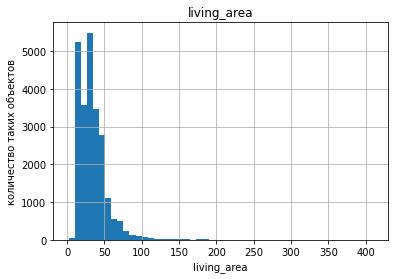

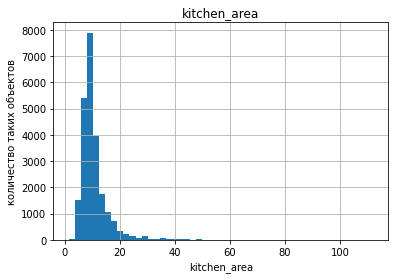

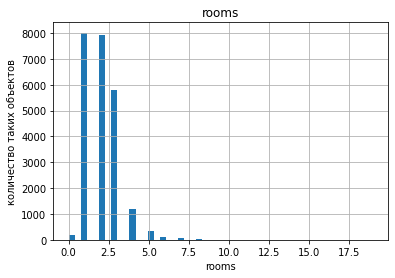

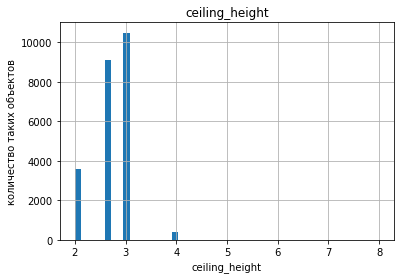

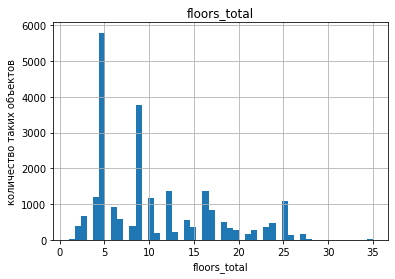

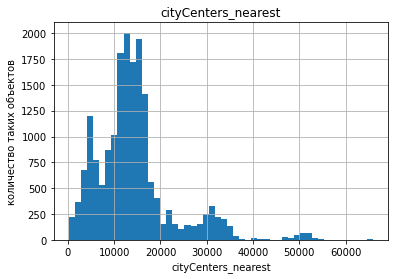

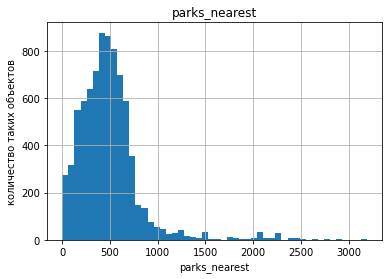

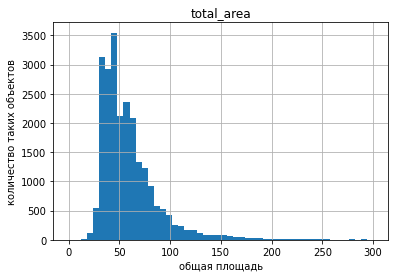

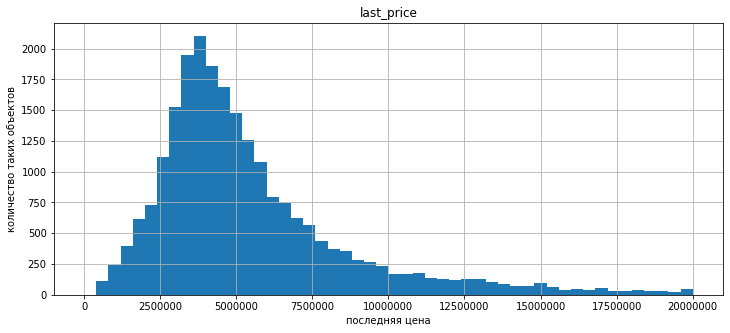

In [11]:
hists = [
    'living_area', 'kitchen_area', 'rooms', 'ceiling_height',
    'floors_total', 'cityCenters_nearest', 'parks_nearest'
]
for graph in hists:
    data_plot = data[graph].hist(bins=50)
    data_plot.set_xlabel(data[graph].name)
    data_plot.set_ylabel('количество таких объектов')
    data_plot.set_title(graph)
    plt.ticklabel_format(style='plain', axis='x')
    plt.show()
    

a = data['total_area'].hist(bins=50, range=(0, 300))
a.set_xlabel('общая площадь')
a.set_ylabel('количество таких объектов')
a.set_title('total_area')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

b = data['last_price'].hist(bins=50, range=(0, 20000000), figsize=(12, 5))
b.set_xlabel('последняя цена')
b.set_ylabel('количество таких объектов')
b.set_title('last_price')
plt.ticklabel_format(style='plain', axis='x')
plt.show()


из наблюдений большинство квартир находятся в диапозонах  
от 20 до 50 кв метров жилой площади  
от 2.5млн до 6млн  
от 1 до 28 этажных зданиях, с заметными пиками 5 и 10 этажками  
от 30 до 60 метров кв в общем  
от 8 до 12 метров кухня  
в основном 1, 2, чуть меньше 3 комнаты и больше совсем мало  
от 2х до 3х метров потолки  
от 500 до 1800 м до центра  
до 600 метров до парка  

большинство графиков похожи на распределения Пуассона, однако график расстояния до центра города немного выбивается, вероятно аномалия

## Изучим как быстро продавались квартиры

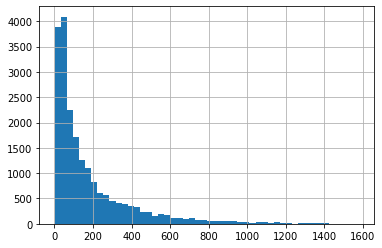

95.0


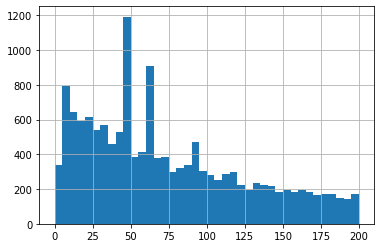

In [12]:
data['days_exposition'].hist(bins=50)
plt.show()
print(data['days_exposition'].median())
data['days_exposition'].describe()
data['days_exposition'].hist(bins=40, range=(0, 200))
plt.show()

среднее: 180  
медиана: 95  
сверхбыстрыми можно считать продажи за несколько дней (до 3) и необычно долгими за 232 дней и больше  
однако есть два аномальных пика на значениях в 45-50 и 65-70 

## Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта

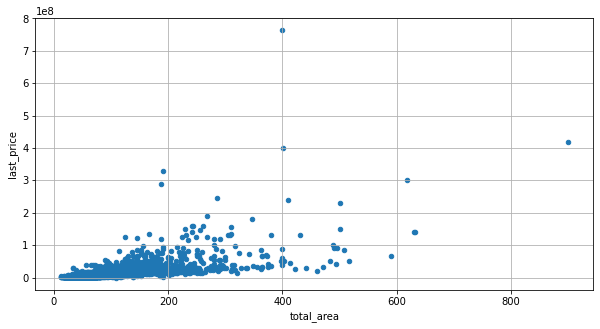

0.6536420464525461


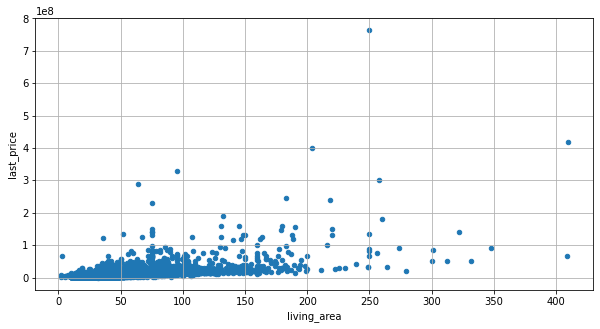

0.5630732424925797


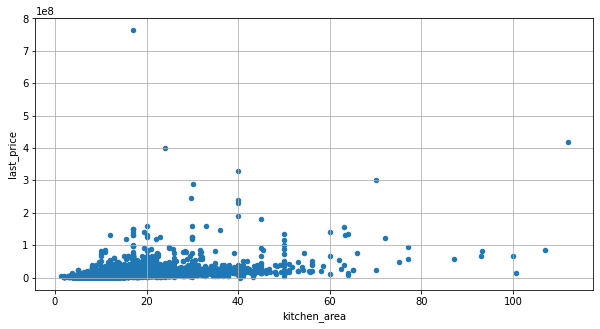

0.46312544697805036


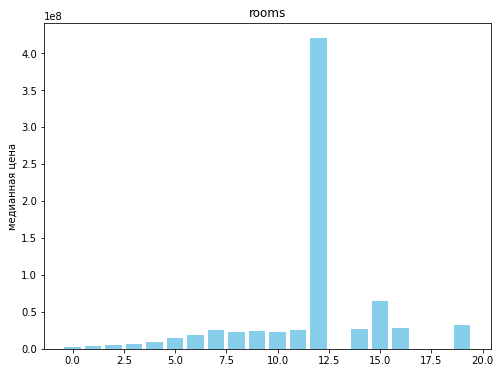

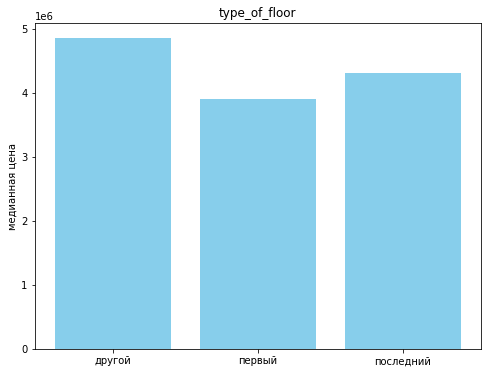

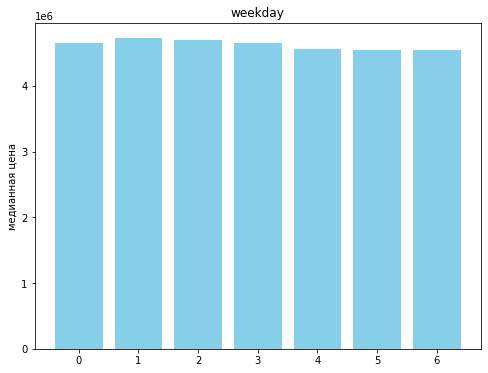

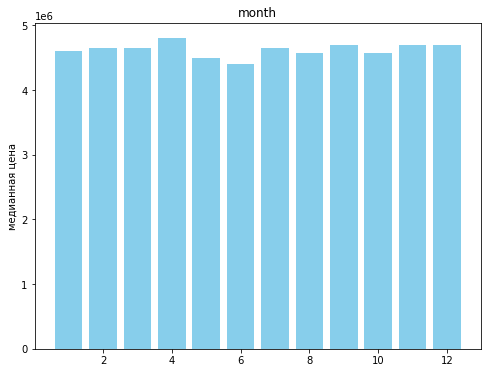

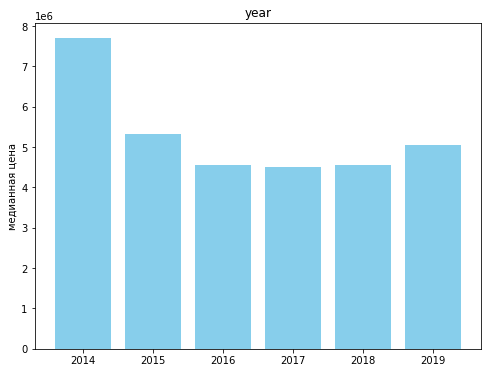

In [13]:
columns_factor = ['total_area', 'living_area', 'kitchen_area']
category_factor = ['rooms', 'type_of_floor', 'weekday', 'month', 'year']
for i in columns_factor:
    data.plot(x=i, y='last_price', kind='scatter', grid=True, figsize=(10, 5))
    if data[i].dtype != 'object' and i=='rooms':
        plt.xticks(range(min(data[i]), max(data[i]) + 1))
        plt.ticklabel_format(style='plain', axis='x')
    plt.show()
    if data[i].dtype != 'object':
        print(data[i].corr(data['last_price']))
        
        
for a in category_factor:
    median_prices = data.groupby(a)['last_price'].median().reset_index()
    plt.figure(figsize=(8, 6))
    plt.bar(median_prices[a], median_prices['last_price'], color='skyblue')
    plt.ylabel('медианная цена')
    plt.title(a)



цена квартиры возрастает с ростом площади примерно до отметки в 400 кв м, далее цена от площади не особо зависит  
то же самое относительно жилой площади, но до отметки в 100 кв м  
то же самое относительно площади кухни, но до отметки в 20 кв м  
при повышении количества комнат цена растет равномерно до отметки в 5 комнат, после чего плавно спадает  
на первом этаже квартиры обычно дешевле чем на других, между "другим" этажом и последним нет особой разницы  
день недели, в который публикуют обьявления обычно не влияет на цену, кроме пятницы, в нее чуть чуть дороже квартиры публикуют  месяц публикации не влияет на цену квартиры
в 2014 по эти данным обычно квартиры были дороже, потом с 2015 по 2019 были дешевле

## Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [14]:
locality_price = data.pivot_table(index='locality_name', values='price_square_meter', aggfunc=['count', 'mean'])
locality_price.columns=['count', 'price_per_m']
locality_price.sort_values(by='count', ascending=False).head(10)


,count,price_per_m
locality_name,,
санкт-петербург,15641,114844.134110
мурино,586,86041.116024
кудрово,470,95260.846128
шушары,439,78551.344647
всеволожск,398,68654.473970
пушкин,369,103125.819377
колпино,338,75424.579112
парголово,327,90175.913089
гатчина,307,68746.146515


самыми дорогими за квадратный метр оказались пушкин и санкт-петербург, однако в зеленогорске достаточно мало обьявлений чтобы делать вывод, что это самый дорогой населенный пункт в ленобласти  
самыми дешевыми из 10 самых населенных пунктов оказались выборг и всеволожск

## Выделим квартиры в Санкт-Петербурге и вычислим их среднюю стоимость на разном удалении от центра

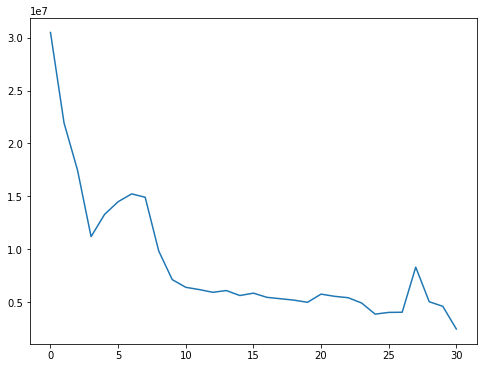

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,total_area_category,price_square_meter,weekday,month,year,type_of_floor,cityCenters_km
748,13,14350000.0,74.0,2017-11-28,2,3.00,5.0,30.0,3,False,...,0.0,NaN,128.0,very_big,193918.92,1,11,2017,другой,27.0
5961,6,2250000.0,32.0,2018-02-27,1,2.65,2.0,16.5,2,False,...,0.0,NaN,178.0,medium,70312.50,1,2,2018,последний,27.0


In [15]:
data['cityCenters_km'] = round(data['cityCenters_km'])
aa = data.query('locality_name == "санкт-петербург"').pivot_table(index='cityCenters_km', values='last_price')
plt.figure(figsize=(8, 6))
plt.plot(aa.index, aa['last_price'], linestyle='-', label='price_by_km')
plt.show()
data.query('locality_name == "санкт-петербург" and cityCenters_km == 27').sort_values(by='last_price', ascending=False)

цена квартир сильно падает с каджым киломентром от центра с 0 до 8 км, после чего плавно спадает дальше, однако в 27км от центра Питера находится всего 2 обьекта, что создает аномалию средней цены


## Общий вывод

цены в питере больше, чем в области, на первом этаже дешевле, до определенного момента при повышении площади общей, жилой и кухонной цена растет, после чего стабильна, чем ближе к центру тем дороже, часто рядом парки и пруды

цена квартиры возрастает с ростом площади примерно до отметки в 400 кв м, далее цена от площади не особо зависит  
то же самое относительно жилой площади, но до отметки в 100 кв м  
то же самое относительно площади кухни, но до отметки в 20 кв м  
при повышении количества комнат цена растет равномерно до отметки в 5 комнат, после чего плавно спадает  
на первом этаже квартиры обычно дешевле чем на других, между "другим" этажом и последним нет особой разницы  
день недели, в который публикуют обьявления обычно не влияет на цену, кроме пятницы, в нее чуть чуть дороже квартиры публикуют  месяц публикации не влияет на цену квартиры
в 2014 по эти данным обычно квартиры были дороже, потом с 2015 по 2019 были дешевле

цена квартир сильно падает с каджым киломентром от центра с 0 до 8 км, после чего плавно спадает дальше, однако в 27км от центра Питера находится всего 2 обьекта, что создает аномалию средней цены

самыми дорогими за квадратный метр оказались пушкин и санкт-петербург, однако в зеленогорске достаточно мало обьявлений чтобы делать вывод, что это самый дорогой населенный пункт в ленобласти  
самыми дешевыми из 10 самых населенных пунктов оказались выборг и всеволожск

чтобы повысить качество сбора данных могу посоветовать проверить алгоритнмы, связанные с геопозицией обьектов, передачи данных, их хранения на наличие багов